In [1]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk


# download stopwords & punkt & VADER
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
tweets_df = pd.read_csv('tweets.csv')
#movie_id is one above what it is supposed to be in movies_df
tweets_df['movie_id'] = tweets_df['movie_id'] - 1
tweets_df.head()

,tweet,movie,movie_id
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0


In [3]:
movies_df = pd.read_csv('processed_movies.csv')
movies_df['Released'] = movies_df['Released'].apply(pd.to_datetime) #transforms our string values in column Released into a datetime object
movies_df.columns = ['released', 'movie', 'domestic', 'international', 'worldwide']
movies_df.head()

,released,movie,domestic,international,worldwide
0,2021-12-17,Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
1,2021-09-03,Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
2,2021-10-01,Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
3,2021-07-09,Black Widow,"$183,651,655","$196,100,000","$379,751,655"
4,2021-06-25,F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"


In [4]:
# Process the tweets first
def clean_text(text):
# Removes all special characters and numericals leaving the alphabets
    to_return = ''
    for word in text.split():
        if not '@' in word and not 'https:' in word:
            to_return += word + " "

    to_return = to_return.replace("#","")
    return to_return[0:len(to_return)-1]

test_clean = clean_text(tweets_df.iloc[0]['tweet'])
tweets_df["tweet_clean"] = tweets_df['tweet'].apply(clean_text)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...


In [5]:
# Tokenize
from nltk.tokenize import word_tokenize
tweets_df['tweet_token'] = tweets_df['tweet_clean'].apply(word_tokenize)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]"
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,..."


In [6]:
# Remove stop words

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tweets_df['tweet_stop'] = tweets_df['tweet_token'].apply(lambda x: [item for item in x if item not in stop_words])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,..."


In [7]:
# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()

tweets_df['tweet_stem'] = tweets_df['tweet_stop'].apply(lambda x: [ps.stem(y) for y in x])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop,tweet_stem
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !...","[spiderman, save, movi, go, experi, !, !, !]"
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,...","[yes-, good, !, grab, extra, napkin, popcorn, ..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,...","[“, spider, man, trailer, stock, price, ”, …, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed],[obsess]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,...","[look, forward, spider-man, tonight, ., if, an..."


In [8]:
#DO OTHER STUFF TO SEE FREQ DISTRIBUTION

In [9]:
# VADER sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
test_tweet = tweets_df.iloc[0]['tweet_clean']
print(test_tweet)
print(analyser.polarity_scores(test_tweet))

SpiderMan has saved the movie going experience!!!
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5684}


In [10]:
sentiment_df = pd.DataFrame()
sentiment_df['movie_id'] = tweets_df['movie_id']
sentiment_df['tweet_clean'] = tweets_df['tweet_clean']
sentiment_df['sentiment'] = tweets_df['tweet_clean'].apply(analyser.polarity_scores)
sentiment_df.head()

,movie_id,tweet_clean,sentiment
0,0,SpiderMan has saved the movie going experience!!!,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou..."
1,0,Yes- so good! Grab extra napkins with your pop...,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."
2,0,“Spider Man trailer and stock prices”… Story |...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,0,too obsessed,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou..."
4,0,Looking forward to Spider-Man tonight. If anyo...,"{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compou..."


In [11]:
def spread_sentiment(sentiment_obj, category):
    return sentiment_obj[category]
sentiment_df['compound'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'compound'))
sentiment_df['neg'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neg'))
sentiment_df['neu'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neu'))
sentiment_df['pos'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'pos'))
sentiment_df.drop(columns=['sentiment'], inplace=True)
sentiment_df.head()

,movie_id,tweet_clean,compound,neg,neu,pos
0,0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38
1,0,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34
2,0,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00
3,0,too obsessed,-0.1779,0.63,0.37,0.00
4,0,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00


In [12]:
# assign labels
def compound_to_label(compound_score):
    if(compound_score >= 0.05): return 'pos'
    if(compound_score <= -0.05): return 'neg'
    return 'neu'

sentiment_df['label'] = sentiment_df['compound'].apply(compound_to_label)
sentiment_df.head()

,movie_id,tweet_clean,compound,neg,neu,pos,label
0,0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38,pos
1,0,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34,pos
2,0,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00,neu
3,0,too obsessed,-0.1779,0.63,0.37,0.00,neg
4,0,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00,neg


In [13]:
# Drop neutral ones
print('before', sentiment_df.shape)
sentiment_df.drop(sentiment_df[sentiment_df.label == 'neu'].index, inplace=True)
print('after', sentiment_df.shape)

before (801929, 7)
after (650046, 7)


### Connections between Compound Scores and Worldwide Box Office

In [58]:
correlation_df = pd.DataFrame()
correlation_df['compound'] = sentiment_df['compound'].reset_index(drop=True)
correlation_df['worldwide'] = movies_df.iloc[sentiment_df['movie_id']]['worldwide'].reset_index(drop=True)
correlation_df.head()

,compound,worldwide
0,0.5684,"$1,888,426,351"
1,0.7339,"$1,888,426,351"
2,-0.1779,"$1,888,426,351"
3,-0.6875,"$1,888,426,351"
4,0.4215,"$1,888,426,351"


In [59]:
def std_cash(string):
    string = string.replace('$','').replace(',','')
    return float(string)
correlation_df['worldwide'] = correlation_df['worldwide'].apply(std_cash)

<AxesSubplot:xlabel='compound', ylabel='worldwide'>

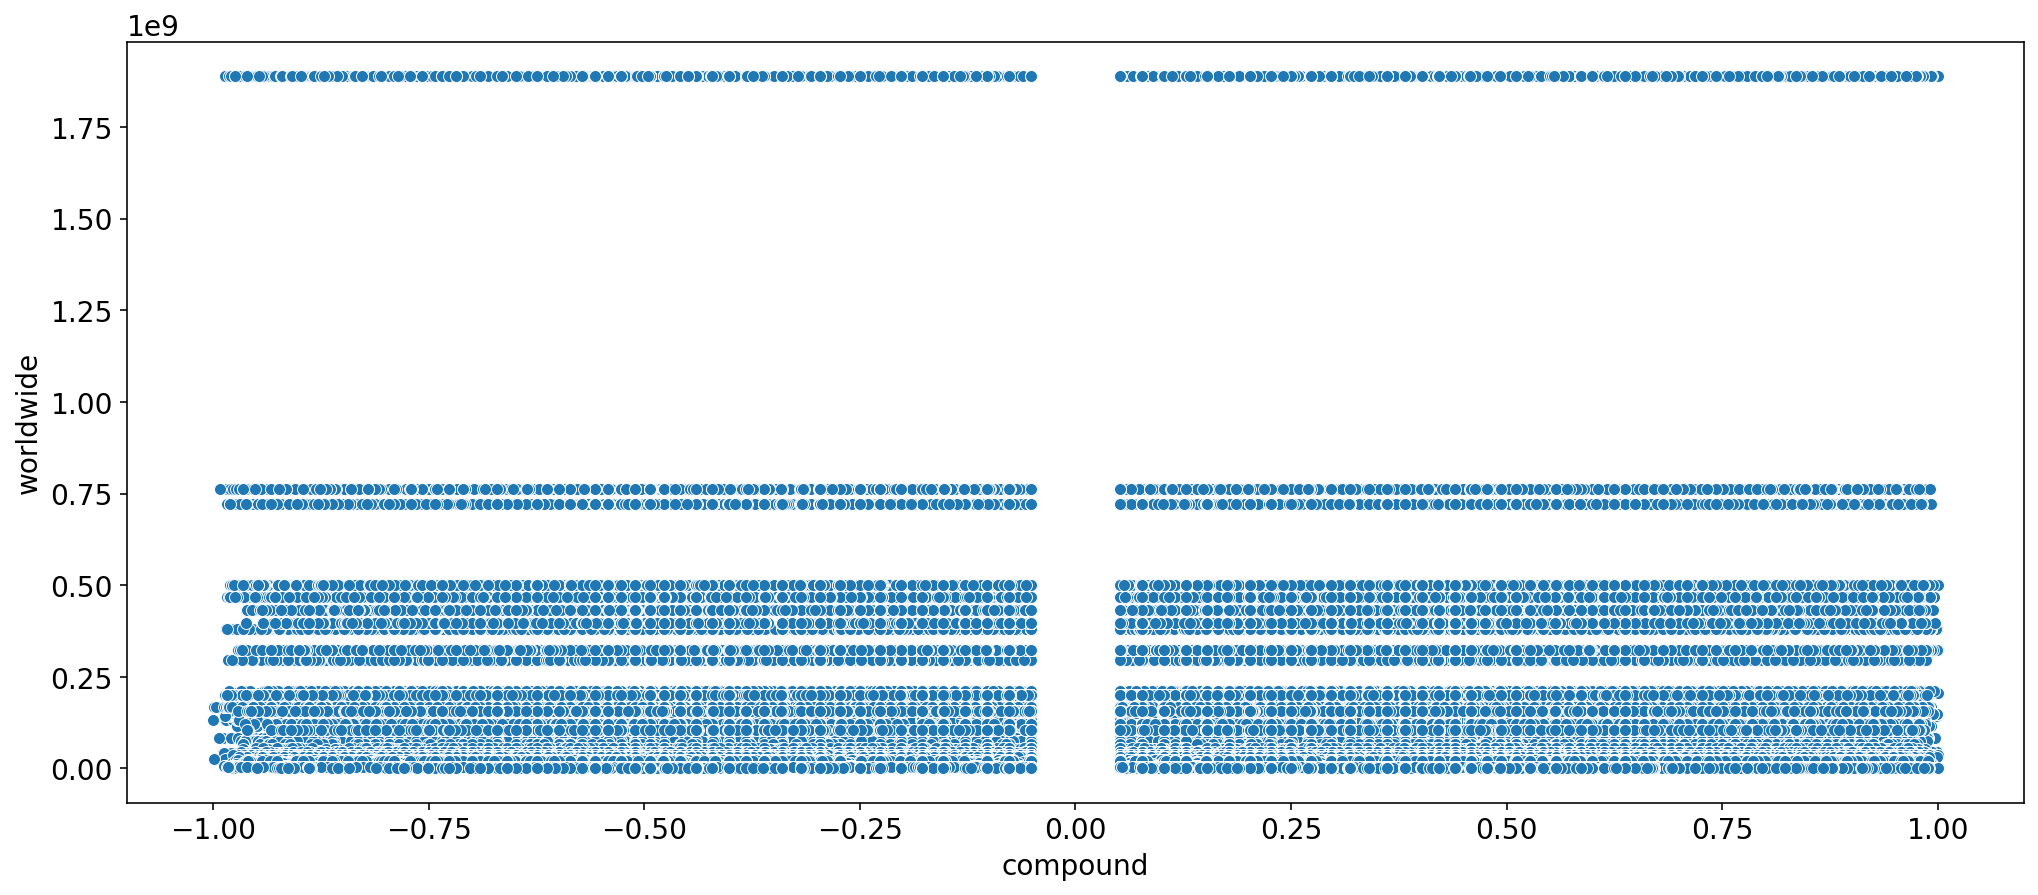

In [60]:
sns.scatterplot(x='compound', y='worldwide', data=correlation_df)

### Correlation Between Average Movie Tweet Score & Worldwide Box Office

In [66]:
sentiment_averages = []
total_tweets = []
for movie_id in range(0,100):
    movie_series = sentiment_df[sentiment_df['movie_id'] == movie_id]['compound']
    sentiment_avg = np.sum(movie_series) / len(movie_series)
    sentiment_averages.append(sentiment_avg)
    total_tweets.append(len(movie_series))

avg_sentiment_series = pd.Series(sentiment_averages)
total_tweets_series = pd.Series(total_tweets)

avg_correlation_df = pd.DataFrame()
avg_correlation_df['worldwide'] = movies_df['worldwide']
avg_correlation_df['worldwide'] = avg_correlation_df['worldwide'].apply(std_cash)
avg_correlation_df['avg_compound'] = avg_sentiment_series
avg_correlation_df['tweet_count'] = total_tweets_series
avg_correlation_df.head()

,worldwide,avg_compound,tweet_count
0,1.888426e+09,0.233681,99490
1,4.322433e+08,0.453776,19096
2,5.016004e+08,0.265929,40366
3,3.797517e+08,0.319763,62438
4,7.210779e+08,0.040956,13301


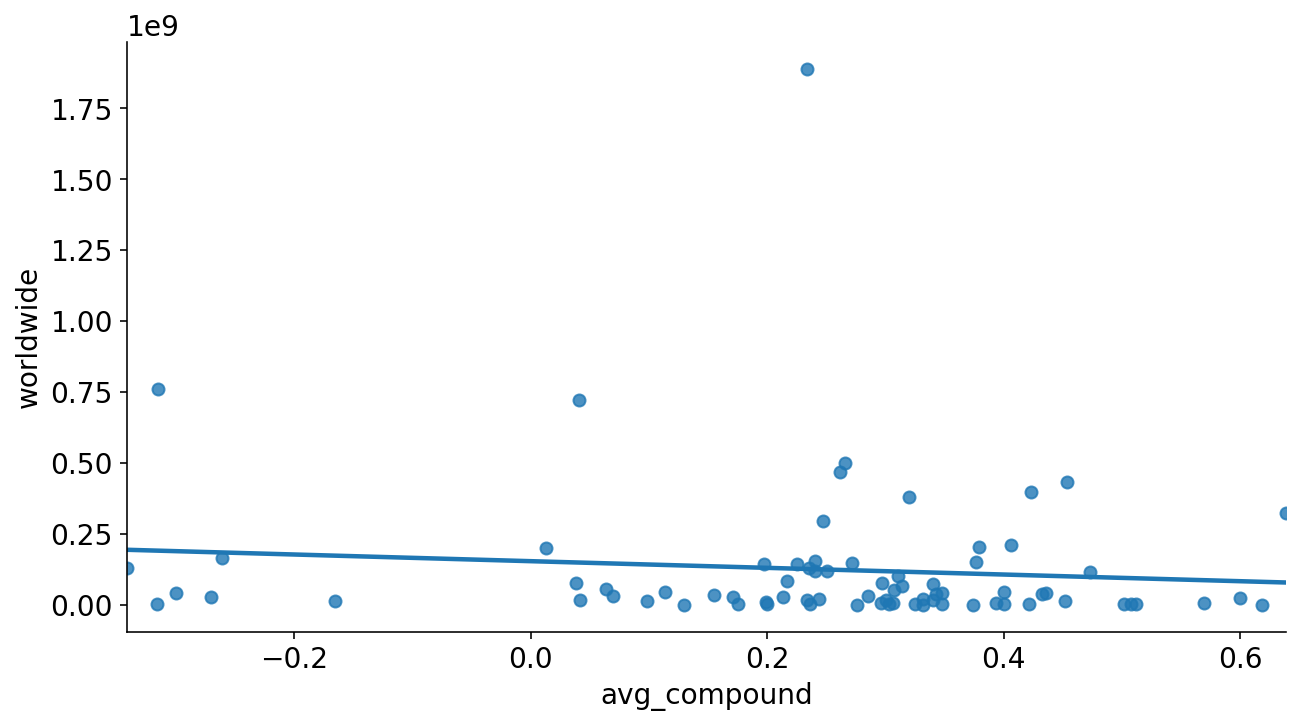

In [65]:
sns.lmplot(x='avg_compound', y='worldwide', data=avg_correlation_df, ci=None, aspect=1.8)

In [19]:
outcome, predictors = patsy.dmatrices('worldwide ~ avg_compound', avg_correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              worldwide   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7393
Date:                Sun, 05 Jun 2022   Prob (F-statistic):              0.393
Time:                        14:06:35   Log-Likelihood:                -1599.4
No. Observations:                  77   AIC:                             3203.
Df Residuals:                      75   BIC:                             3208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.549e+08   4.49e+07      3.449   

### Correlation Between Movie Tweet Count & Worldwide Box Office

In [20]:
avg_correlation_df

,worldwide,avg_compound,tweet_count
0,1.888426e+09,0.233681,99490
1,4.322433e+08,0.453776,19096
2,5.016004e+08,0.265929,40366
3,3.797517e+08,0.319763,62438
4,7.210779e+08,0.040956,13301
...,...,...,...
95,1.436324e+06,0.331573,35273
96,1.738764e+06,0.129402,212
97,3.643760e+06,-0.316178,2560
98,1.252925e+06,0.374435,85


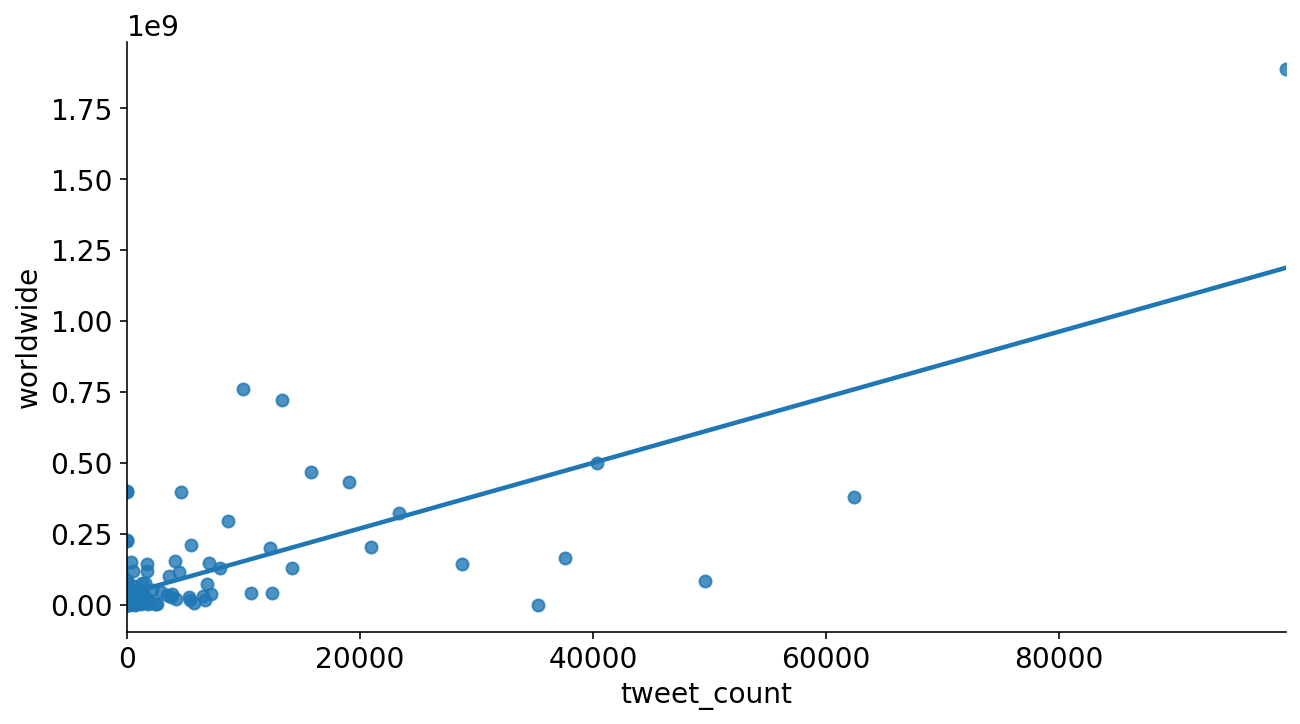

In [47]:
sns.lmplot(x='tweet_count', y='worldwide', data=avg_correlation_df,
          ci=None, aspect=1.8)

In [22]:
outcome, predictors = patsy.dmatrices('worldwide ~ tweet_count', avg_correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              worldwide   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     99.68
Date:                Sun, 05 Jun 2022   Prob (F-statistic):           1.31e-16
Time:                        14:06:35   Log-Likelihood:                -2033.0
No. Observations:                 100   AIC:                             4070.
Df Residuals:                      98   BIC:                             4075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.914e+07   1.81e+07      2.159      

### Correlation Between Tweet Count & Worldwide Box Office Seperated by Average Sentiment Per Movie

In [28]:
avg_correlation_df['avg_sentiment'] = avg_correlation_df['avg_compound'].apply(compound_to_label)
avg_correlation_df.head()

,worldwide,avg_compound,tweet_count,avg_sentiment
0,1.888426e+09,0.233681,99490,pos
1,4.322433e+08,0.453776,19096,pos
2,5.016004e+08,0.265929,40366,pos
3,3.797517e+08,0.319763,62438,pos
4,7.210779e+08,0.040956,13301,neu


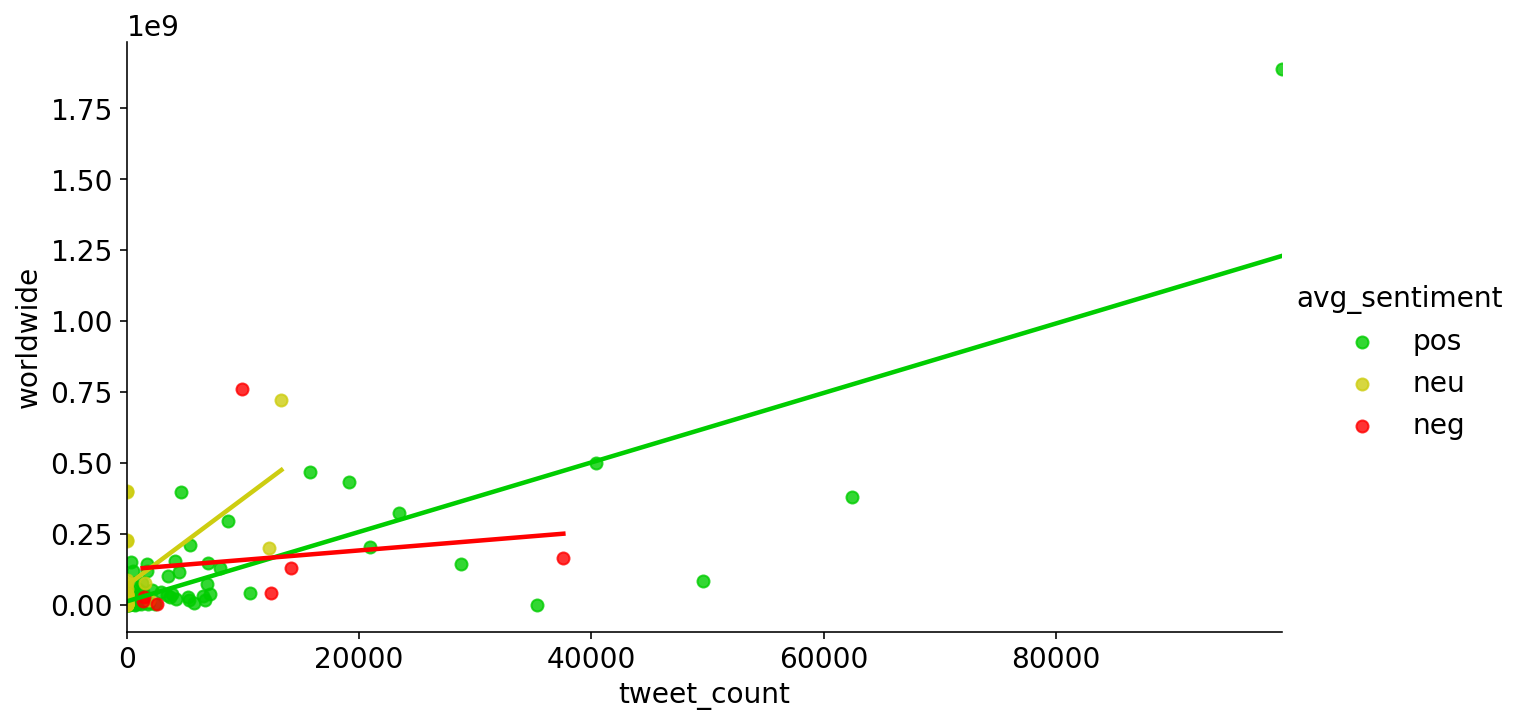

In [48]:
palette = dict(zip(['pos', 'neu', 'neg'], sns.color_palette(['#00cd00','#cdcd11','#ff0000'])))
sns.lmplot(x='tweet_count', y='worldwide', hue='avg_sentiment', 
           data=avg_correlation_df, palette=palette, ci=None, aspect=1.8)